<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
# default_exp models.tacotron2

In [ ]:
# export
from torch import nn
from uberduck_ml_dev.models.base import TTSModel
from uberduck_ml_dev.models.common import Attention, Conv1d, LinearNorm, GST
from uberduck_ml_dev.text.symbols import symbols
from uberduck_ml_dev.vendor.tfcompat.hparam import HParams
from uberduck_ml_dev.utils.utils import to_gpu, get_mask_from_lengths
import numpy as np
import torch
from torch.autograd import Variable
from torch.cuda.amp import autocast
from torch.nn import functional as F


class Decoder(nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step_initial = hparams.n_frames_per_step_initial
        self.n_frames_per_step_current = hparams.n_frames_per_step_initial
        self.encoder_embedding_dim = hparams.encoder_embedding_dim
        self.attention_rnn_dim = hparams.attention_rnn_dim
        self.decoder_rnn_dim = hparams.decoder_rnn_dim
        self.prenet_dim = hparams.prenet_dim
        self.max_decoder_steps = hparams.max_decoder_steps
        self.gate_threshold = hparams.gate_threshold
        self.p_attention_dropout = hparams.p_attention_dropout
        self.p_decoder_dropout = hparams.p_decoder_dropout
        self.p_teacher_forcing = hparams.p_teacher_forcing

        self.prenet = Prenet(
            hparams.n_mel_channels,
            [hparams.prenet_dim, hparams.prenet_dim],
        )

        self.attention_rnn = nn.LSTMCell(
            hparams.prenet_dim + self.encoder_embedding_dim,
            hparams.attention_rnn_dim,
        )

        self.attention_layer = Attention(
            hparams.attention_rnn_dim,
            self.encoder_embedding_dim,
            hparams.attention_dim,
            hparams.attention_location_n_filters,
            hparams.attention_location_kernel_size,
            fp16_run=hparams.fp16_run,
        )

        self.decoder_rnn = nn.LSTMCell(
            hparams.attention_rnn_dim + self.encoder_embedding_dim,
            hparams.decoder_rnn_dim,
            1,
        )

        self.linear_projection = LinearNorm(
            hparams.decoder_rnn_dim + self.encoder_embedding_dim,
            hparams.n_mel_channels * hparams.n_frames_per_step_initial,
        )

        self.gate_layer = LinearNorm(
            hparams.decoder_rnn_dim + self.encoder_embedding_dim,
            1,
            bias=True,
            w_init_gain="sigmoid",
        )

    def set_current_frames_per_step(self, n_frames: int):
        self.n_frames_per_step_current = n_frames

    def get_go_frame(self, memory):
        """Gets all zeros frames to use as first decoder input
        PARAMS
        ------
        memory: decoder outputs

        RETURNS
        -------
        decoder_input: all zeros frames
        """
        B = memory.size(0)
        decoder_input = Variable(memory.data.new(B, self.n_mel_channels).zero_())
        return decoder_input

    def initialize_decoder_states(self, memory, mask):
        """Initializes attention rnn states, decoder rnn states, attention
        weights, attention cumulative weights, attention context, stores memory
        and stores processed memory
        PARAMS
        ------
        memory: Encoder outputs
        mask: Mask for padded data if training, expects None for inference
        """
        B = memory.size(0)
        MAX_TIME = memory.size(1)

        self.attention_hidden = Variable(
            memory.data.new(B, self.attention_rnn_dim).zero_()
        )
        self.attention_cell = Variable(
            memory.data.new(B, self.attention_rnn_dim).zero_()
        )

        self.decoder_hidden = Variable(memory.data.new(B, self.decoder_rnn_dim).zero_())
        self.decoder_cell = Variable(memory.data.new(B, self.decoder_rnn_dim).zero_())

        self.attention_weights = Variable(memory.data.new(B, MAX_TIME).zero_())
        self.attention_weights_cum = Variable(memory.data.new(B, MAX_TIME).zero_())
        self.attention_context = Variable(
            memory.data.new(B, self.encoder_embedding_dim).zero_()
        )

        self.memory = memory
        self.processed_memory = self.attention_layer.memory_layer(memory)
        self.mask = mask

    def parse_decoder_inputs(self, decoder_inputs):
        """Prepares decoder inputs, i.e. mel outputs
        PARAMS
        ------
        decoder_inputs: inputs used for teacher-forced training, i.e. mel-specs

        RETURNS
        -------
        inputs: processed decoder inputs

        """
        # (B, n_mel_channels, T_out) -> (B, T_out, n_mel_channels)

        decoder_inputs = decoder_inputs.transpose(1, 2)
        decoder_inputs = decoder_inputs.contiguous()
        # print(decoder_inputs.shape, 'dec_in')
        # print(decoder_inputs.size(0), int(decoder_inputs.size(1)), self.n_frames_per_step_current)
        decoder_inputs = decoder_inputs.view(
            decoder_inputs.size(0),
            int(decoder_inputs.size(1) / self.n_frames_per_step_current),
            -1,
        )
        # (B, T_out, n_mel_channels) -> (T_out, B, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(0, 1)
        return decoder_inputs

    def parse_decoder_outputs(self, mel_outputs, gate_outputs, alignments):
        """Prepares decoder outputs for output
        PARAMS
        ------
        mel_outputs:
        gate_outputs: gate output energies
        alignments:

        RETURNS
        -------
        mel_outputs:
        gate_outpust: gate output energies
        alignments:
        """
        # (T_out, B) -> (B, T_out)
        alignments = torch.stack(alignments).transpose(0, 1)
        # (T_out, B) -> (B, T_out)
        gate_outputs = torch.stack(gate_outputs)
        if len(gate_outputs.size()) > 1:
            gate_outputs = gate_outputs.transpose(0, 1)
        else:
            gate_outputs = gate_outputs[None]
        gate_outputs = gate_outputs.contiguous()
        # (B, T_out, n_mel_channels * n_frames_per_step) -> (B, T_out * n_frames_per_step, n_mel_channels)
        mel_outputs = mel_outputs.view(mel_outputs.size(0), -1, self.n_mel_channels)
        # (B, T_out, n_mel_channels) -> (B, n_mel_channels, T_out)
        mel_outputs = mel_outputs.transpose(1, 2)

        return mel_outputs, gate_outputs, alignments

    def decode(self, decoder_input, attention_weights=None):
        """Decoder step using stored states, attention and memory
        PARAMS
        ------
        decoder_input: previous mel output

        RETURNS
        -------
        mel_output:
        gate_output: gate output energies
        attention_weights:
        """
        cell_input = torch.cat((decoder_input, self.attention_context), -1)
        self.attention_hidden, self.attention_cell = self.attention_rnn(
            cell_input, (self.attention_hidden, self.attention_cell)
        )
        self.attention_hidden = F.dropout(
            self.attention_hidden, self.p_attention_dropout, self.training
        )
        self.attention_cell = F.dropout(
            self.attention_cell, self.p_attention_dropout, self.training
        )

        attention_weights_cat = torch.cat(
            (
                self.attention_weights.unsqueeze(1),
                self.attention_weights_cum.unsqueeze(1),
            ),
            dim=1,
        )
        self.attention_context, self.attention_weights = self.attention_layer(
            self.attention_hidden,
            self.memory,
            self.processed_memory,
            attention_weights_cat,
            self.mask,
            attention_weights,
        )

        self.attention_weights_cum += self.attention_weights
        decoder_input = torch.cat((self.attention_hidden, self.attention_context), -1)
        self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
            decoder_input, (self.decoder_hidden, self.decoder_cell)
        )
        self.decoder_hidden = F.dropout(
            self.decoder_hidden, self.p_decoder_dropout, self.training
        )
        self.decoder_cell = F.dropout(
            self.decoder_cell, self.p_decoder_dropout, self.training
        )

        decoder_hidden_attention_context = torch.cat(
            (self.decoder_hidden, self.attention_context), dim=1
        )

        decoder_output = self.linear_projection(decoder_hidden_attention_context)

        gate_prediction = self.gate_layer(decoder_hidden_attention_context)
        return decoder_output, gate_prediction, self.attention_weights

    def forward(self, memory, decoder_inputs, memory_lengths):
        """Decoder forward pass for training
        PARAMS
        ------
        memory: Encoder outputs
        decoder_inputs: Decoder inputs for teacher forcing. i.e. mel-specs
        memory_lengths: Encoder output lengths for attention masking.

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        B = memory.size(0)
        decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
        decoder_inputs = decoder_inputs.reshape(
            -1, decoder_inputs.size(1), self.n_mel_channels
        )
        decoder_input = self.get_go_frame(memory).unsqueeze(0)
        decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
        decoder_inputs = self.prenet(decoder_inputs)

        self.initialize_decoder_states(
            memory, mask=~get_mask_from_lengths(memory_lengths)
        )

        mel_outputs = torch.empty(
            B, 0, self.n_frames_per_step_current * self.n_mel_channels
        )
        if torch.cuda.is_available():
            mel_outputs = mel_outputs.cuda()
        gate_outputs, alignments = [], []
        desired_output_frames = decoder_inputs.size(0) / self.n_frames_per_step_current
        while mel_outputs.size(1) < desired_output_frames - 1:
            if (
                mel_outputs.size(1) == 0
                or np.random.uniform(0.0, 1.0) <= self.p_teacher_forcing
            ):
                teacher_forced_frame = decoder_inputs[
                    mel_outputs.size(1) * self.n_frames_per_step_current
                ]

                to_concat = (teacher_forced_frame,)
                decoder_input = torch.cat(to_concat, dim=1)
            else:

                # NOTE(zach): we may need to concat these as we go to ensure that
                # it's easy to retrieve the last n_frames_per_step_init frames.
                to_concat = (
                    self.prenet(
                        mel_outputs[:, -1, -1 * self.n_frames_per_step_current :]
                    ),
                )
                decoder_input = torch.cat(to_concat, dim=1)
            # NOTE(zach): When training with fp16_run == True, decoder_rnn seems to run into
            # issues with NaNs in gradient, maybe due to vanishing gradients.
            # Disable half-precision for this call to work around the issue.
            with autocast(enabled=False):
                mel_output, gate_output, attention_weights = self.decode(decoder_input)
            mel_outputs = torch.cat(
                [
                    mel_outputs,
                    mel_output[
                        :, 0 : self.n_mel_channels * self.n_frames_per_step_current
                    ].unsqueeze(1),
                ],
                dim=1,
            )
            gate_outputs += [gate_output.squeeze()] * self.n_frames_per_step_current
            alignments += [attention_weights]

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments
        )

        return mel_outputs, gate_outputs, alignments

    def inference(self, memory):
        """Decoder inference
        PARAMS
        ------
        memory: Encoder outputs

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        decoder_input = self.get_go_frame(memory)
        self.initialize_decoder_states(memory, mask=None)

        B = memory.size(0)
        mel_outputs = torch.empty(
            B, 0, self.n_frames_per_step_current * self.n_mel_channels
        )
        if torch.cuda.is_available():
            mel_outputs = mel_outputs.cuda()
        gate_outputs, alignments = [], []
        while True:

            to_cat = (self.prenet(decoder_input),)

            decoder_input = torch.cat(to_cat, dim=1)
            mel_output, gate_output, alignment = self.decode(decoder_input)
            mel_output = mel_output[
                :, 0 : self.n_mel_channels * self.n_frames_per_step_current
            ].unsqueeze(1)

            mel_outputs = torch.cat([mel_outputs, mel_output], dim=1)
            gate_outputs += [gate_output.squeeze()] * self.n_frames_per_step_current
            alignments += [alignment]

            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            elif mel_outputs.size(1) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break

            decoder_input = mel_output[:, -1, -1 * self.n_mel_channels :]

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments
        )

        return mel_outputs, gate_outputs, alignments

    def inference_noattention(self, memory, attention_map):
        """Decoder inference
        PARAMS
        ------
        memory: Encoder outputs

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        decoder_input = self.get_go_frame(memory)

        self.initialize_decoder_states(memory, mask=None)

        B = memory.size(0)
        mel_outputs = torch.empty(
            B, 0, self.n_frames_per_step_current * self.n_mel_channels
        )
        if torch.cuda.is_available():
            mel_outputs = mel_outputs.cuda()
        gate_outputs, alignments = [], []
        for i in range(len(attention_map)):

            attention = attention_map[i]
            decoder_input = torch.cat((self.prenet(decoder_input),), dim=1)
            mel_output, gate_output, alignment = self.decode(decoder_input, attention)
            # mel_output, gate_output, alignment = self.decode(decoder_input)
            mel_output = mel_output[
                :, 0 : self.n_mel_channels * self.n_frames_per_step_current
            ].unsqueeze(1)

            mel_outputs = torch.cat([mel_outputs, mel_output], dim=1)
            gate_outputs += [gate_output.squeeze()] * self.n_frames_per_step_current
            alignments += [alignment]

            decoder_input = mel_output[:, -1, -1 * self.n_mel_channels :]

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments
        )

        return mel_outputs, gate_outputs, alignments

    # def inference_partial_tf(self, memory, decoder_inputs, memory_lengths, tf_until_idx):
    def inference_partial_tf(self, memory, decoder_inputs, tf_until_idx):
        """Decoder inference with teacher-forcing up until tf_until_idx
        PARAMS
        ------
        memory: Encoder outputs
        decoder_inputs: Decoder inputs for teacher forcing. i.e. mel-specs
        memory_lengths: Encoder output lengths for attention masking.

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        if torch.cuda.is_available():
            decoder_inputs = decoder_inputs.cuda()

        B = memory.size(0)
        decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
        decoder_inputs = decoder_inputs.reshape(
            -1, decoder_inputs.size(1), self.n_mel_channels
        )
        decoder_input = self.get_go_frame(memory).unsqueeze(0)
        decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
        decoder_inputs = self.prenet(decoder_inputs)

        # self.initialize_decoder_states(
        #     memory, mask=~get_mask_from_lengths(memory_lengths)
        # )
        self.initialize_decoder_states(memory, mask=None)

        mel_outputs = torch.empty(
            B, 0, self.n_frames_per_step_current * self.n_mel_channels
        )
        if torch.cuda.is_available():
            mel_outputs = mel_outputs.cuda()
        gate_outputs, alignments = [], []

        while True:
            if mel_outputs.size(1) < tf_until_idx:
                teacher_forced_frame = decoder_inputs[
                    mel_outputs.size(1) * self.n_frames_per_step_current
                ]

                to_concat = (teacher_forced_frame,)
                decoder_input = torch.cat(to_concat, dim=1)
            else:

                to_concat = (
                    self.prenet(mel_outputs[:, -1, -1 * self.n_mel_channels :]),
                )
                decoder_input = torch.cat(to_concat, dim=1)
            mel_output, gate_output, attention_weights = self.decode(decoder_input)
            mel_outputs = torch.cat(
                [
                    mel_outputs,
                    # teacher_forced_frame.unsqueeze(1)
                    mel_output[
                        :, 0 : self.n_mel_channels * self.n_frames_per_step_current
                    ].unsqueeze(1),
                ],
                dim=1,
            )
            gate_outputs += [gate_output.squeeze()] * self.n_frames_per_step_current
            alignments += [attention_weights]
            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            elif mel_outputs.size(1) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments
        )

        return mel_outputs, gate_outputs, alignments

In [ ]:
# export


class Prenet(nn.Module):
    def __init__(self, in_dim, sizes):
        super().__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [
                LinearNorm(in_size, out_size, bias=False)
                for (in_size, out_size) in zip(in_sizes, sizes)
            ]
        )
        self.dropout_rate = 0.5

    def forward(self, x):
        for linear in self.layers:
            x = F.dropout(F.relu(linear(x)), p=self.dropout_rate, training=True)
        return x

In [ ]:
# export


class Postnet(nn.Module):
    """Postnet
    - Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self, hparams):
        super(Postnet, self).__init__()
        self.dropout_rate = 0.5
        self.convolutions = nn.ModuleList()

        self.convolutions.append(
            nn.Sequential(
                Conv1d(
                    hparams.n_mel_channels,
                    hparams.postnet_embedding_dim,
                    kernel_size=hparams.postnet_kernel_size,
                    stride=1,
                    padding=int((hparams.postnet_kernel_size - 1) / 2),
                    dilation=1,
                    w_init_gain="tanh",
                ),
                nn.BatchNorm1d(hparams.postnet_embedding_dim),
            )
        )

        for i in range(1, hparams.postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    Conv1d(
                        hparams.postnet_embedding_dim,
                        hparams.postnet_embedding_dim,
                        kernel_size=hparams.postnet_kernel_size,
                        stride=1,
                        padding=int((hparams.postnet_kernel_size - 1) / 2),
                        dilation=1,
                        w_init_gain="tanh",
                    ),
                    nn.BatchNorm1d(hparams.postnet_embedding_dim),
                )
            )

        self.convolutions.append(
            nn.Sequential(
                Conv1d(
                    hparams.postnet_embedding_dim,
                    hparams.n_mel_channels,
                    kernel_size=hparams.postnet_kernel_size,
                    stride=1,
                    padding=int((hparams.postnet_kernel_size - 1) / 2),
                    dilation=1,
                    w_init_gain="linear",
                ),
                nn.BatchNorm1d(hparams.n_mel_channels),
            )
        )

    def forward(self, x):
        for i in range(len(self.convolutions) - 1):
            x = F.dropout(
                torch.tanh(self.convolutions[i](x)), self.dropout_rate, self.training
            )
        x = F.dropout(self.convolutions[-1](x), self.dropout_rate, self.training)

        return x

In [ ]:
# export
class Encoder(nn.Module):
    """Encoder module:
    - Three 1-d convolution banks
    - Bidirectional LSTM
    """

    def __init__(self, hparams):
        super().__init__()

        convolutions = []
        for _ in range(hparams.encoder_n_convolutions):
            conv_layer = nn.Sequential(
                Conv1d(
                    hparams.encoder_embedding_dim,
                    hparams.encoder_embedding_dim,
                    kernel_size=hparams.encoder_kernel_size,
                    stride=1,
                    padding=int((hparams.encoder_kernel_size - 1) / 2),
                    dilation=1,
                    w_init_gain="relu",
                ),
                nn.BatchNorm1d(hparams.encoder_embedding_dim),
            )
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)
        self.dropout_rate = 0.5

        self.lstm = nn.LSTM(
            hparams.encoder_embedding_dim,
            int(hparams.encoder_embedding_dim / 2),
            1,
            batch_first=True,
            bidirectional=True,
        )

    def forward(self, x, input_lengths):
        if x.size()[0] > 1:
            print("here")
            x_embedded = []
            for b_ind in range(x.size()[0]):  # TODO: Speed up
                curr_x = x[b_ind : b_ind + 1, :, : input_lengths[b_ind]].clone()
                for conv in self.convolutions:
                    curr_x = F.dropout(
                        F.relu(conv(curr_x)), self.dropout_rate, self.training
                    )
                x_embedded.append(curr_x[0].transpose(0, 1))
            x = torch.nn.utils.rnn.pad_sequence(x_embedded, batch_first=True)
        else:
            for conv in self.convolutions:
                x = F.dropout(F.relu(conv(x)), self.dropout_rate, self.training)
            x = x.transpose(1, 2)

        # pytorch tensor are not reversible, hence the conversion
        input_lengths = input_lengths.cpu().numpy()
        x = nn.utils.rnn.pack_padded_sequence(x, input_lengths, batch_first=True)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs

    def inference(self, x):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), self.dropout_rate, self.training)

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs

In [ ]:
# export

DEFAULTS = HParams(
    symbols_embedding_dim=512,
    decay_start=15000,
    decay_rate=8000,
    mask_padding=True,
    fp16_run=False,
    n_mel_channels=80,
    # encoder parameters
    encoder_kernel_size=5,
    encoder_n_convolutions=3,
    encoder_embedding_dim=512,
    # decoder parameters
    coarse_n_frames_per_step=None,
    n_frames_per_step_initial=1,
    decoder_rnn_dim=1024,
    prenet_dim=256,
    prenet_f0_n_layers=1,
    prenet_f0_dim=1,
    prenet_f0_kernel_size=1,
    prenet_rms_dim=0,
    prenet_fms_kernel_size=1,
    max_decoder_steps=1000,
    gate_threshold=0.5,
    p_attention_dropout=0.1,
    p_decoder_dropout=0.1,
    p_teacher_forcing=1.0,
    pos_weight=None,
    # attention parameters
    attention_rnn_dim=1024,
    attention_dim=128,
    # location layer parameters
    attention_location_n_filters=32,
    attention_location_kernel_size=31,
    # mel post-processing network parameters
    postnet_embedding_dim=512,
    postnet_kernel_size=5,
    postnet_n_convolutions=5,
    # speaker_embedding
    n_speakers=1,
    speaker_embedding_dim=128,
    # reference encoder
    with_gst=True,
    ref_enc_filters=[32, 32, 64, 64, 128, 128],
    ref_enc_size=[3, 3],
    ref_enc_strides=[2, 2],
    ref_enc_pad=[1, 1],
    ref_enc_gru_size=128,
    symbol_set="nvidia_taco2",
    num_heads=8,
)

In [ ]:
# export
class Tacotron2(TTSModel):
    def __init__(self, hparams):
        super().__init__(hparams)

        self.mask_padding = hparams.mask_padding
        self.fp16_run = hparams.fp16_run
        self.pos_weight = hparams.pos_weight
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step_initial = hparams.n_frames_per_step_initial
        self.n_frames_per_step_current = hparams.n_frames_per_step_initial
        self.embedding = nn.Embedding(self.n_symbols, hparams.symbols_embedding_dim)
        std = np.sqrt(2.0 / (self.n_symbols + hparams.symbols_embedding_dim))
        val = np.sqrt(3.0) * std  # uniform bounds for std
        self.embedding.weight.data.uniform_(-val, val)
        self.encoder = Encoder(hparams)
        self.decoder = Decoder(hparams)
        self.postnet = Postnet(hparams)

    def parse_batch(self, batch):
        (
            text_padded,
            input_lengths,
            mel_padded,
            gate_padded,
            output_lengths,
            speaker_ids,
            *_,
        ) = batch

        text_padded = to_gpu(text_padded).long()
        input_lengths = to_gpu(input_lengths).long()
        max_len = torch.max(input_lengths.data).item()
        mel_padded = to_gpu(mel_padded).float()
        gate_padded = to_gpu(gate_padded).float()
        output_lengths = to_gpu(output_lengths).long()
        ret_x = [
            text_padded,
            input_lengths,
            mel_padded,
            max_len,
            output_lengths,
            speaker_ids,
        ]
        return (
            tuple(ret_x),
            (mel_padded, gate_padded),
        )

    def parse_output(self, outputs, output_lengths=None):
        if self.mask_padding and output_lengths is not None:
            mask = ~get_mask_from_lengths(output_lengths)
            mask = mask.expand(self.n_mel_channels, mask.size(0), mask.size(1))
            mask = F.pad(mask, (0, outputs[0].size(2) - mask.size(2)))
            mask = mask.permute(1, 0, 2)

            outputs[0].data.masked_fill_(mask, 0.0)
            outputs[1].data.masked_fill_(mask, 0.0)
            outputs[2].data.masked_fill_(mask[:, 0, :], 1e3)  # gate energies

        return outputs

    def forward(self, inputs):
        (
            input_text,
            input_lengths,
            targets,
            max_len,
            output_lengths,
            *_,
        ) = inputs

        input_lengths, output_lengths = input_lengths.data, output_lengths.data

        embedded_inputs = self.embedding(input_text).transpose(1, 2)
        embedded_text = self.encoder(embedded_inputs, input_lengths)

        encoder_outputs = torch.cat((embedded_text,), dim=2)

        mel_outputs, gate_outputs, alignments = self.decoder(
            encoder_outputs, targets, memory_lengths=input_lengths
        )

        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        return self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments], output_lengths
        )

    @torch.no_grad()
    def inference(self, inputs):
        text, speaker_ids, *_ = inputs

        embedded_inputs = self.embedding(text).transpose(1, 2)
        embedded_text = self.encoder.inference(embedded_inputs)

        encoder_outputs = torch.cat((embedded_text,), dim=2)

        mel_outputs, gate_outputs, alignments = self.decoder.inference(encoder_outputs)

        print(mel_outputs.shape)
        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        return self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments]
        )

    @torch.no_grad()
    def inference_noattention(self, inputs):
        """Run inference conditioned on an attention map.

        NOTE(zach): I don't think it is necessary to do a version
        of this without f0s passed as well, since it seems like we
        would always want to condition on pitch when conditioning on rhythm.
        """
        text, attention_map = inputs
        embedded_inputs = self.embedding(text).transpose(1, 2)
        embedded_text = self.encoder.inference(embedded_inputs)

        encoder_outputs = torch.cat((embedded_text,), dim=2)

        mel_outputs, gate_outputs, alignments = self.decoder.inference_noattention(
            encoder_outputs, attention_map
        )
        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        return self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments]
        )

    @torch.no_grad()
    def inference_partial_tf(
        self,
        inputs,
        tf_mel,
        # tf_mel_postnet,
        tf_until_idx,
        # encoder_until_idx,
        # original_sequence,
    ):
        """Run inference with partial teacher forcing.

        tf_mel: (B, T, n_mel_channels)
        """
        # assert (
        #     tf_mel.shape[2] == self.n_mel_channels
        # ), "Shape of teacher forced mel should be (B, T, n_mel_channels)"
        text, *_ = inputs
        embedded_inputs = self.embedding(text).transpose(1, 2)
        embedded_text = self.encoder.inference(embedded_inputs)
        encoder_outputs = torch.cat((embedded_text,), dim=2)

        # print("encoder outputs shape: ", encoder_outputs.shape)
        # original_embedded_inputs = self.embedding(original_sequence).transpose(1, 2)
        # original_embedded_text = self.encoder.inference(original_embedded_inputs)
        # original_encoder_outputs = torch.cat((original_embedded_text,), dim=2)
        #
        # encoder_outputs[:, :encoder_until_idx, :] = original_encoder_outputs[:, :encoder_until_idx, :]

        mel_outputs, gate_outputs, alignments = self.decoder.inference_partial_tf(
            encoder_outputs,
            tf_mel,
            tf_until_idx,
        )

        print(mel_outputs.shape)
        # mel_outputs[:, :, :tf_until_idx] = tf_mel.transpose(1, 2)[:, :, :tf_until_idx]
        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        return self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments]
        )

In [ ]:
from uberduck_ml_dev.data_loader import MelSTFT
from uberduck_ml_dev.text.symbols import NVIDIA_TACO2_SYMBOLS
from uberduck_ml_dev.text.util import text_to_sequence
from uberduck_ml_dev.utils.plot import plot_attention, plot_attention_phonemes
from uberduck_ml_dev.vocoders.hifigan import HiFiGanGenerator

from IPython.display import display, Audio

model = Tacotron2(DEFAULTS)
loaded = torch.load("../models/tacotron2-eminem-arpabet-400-2021-12-14.pt")
model.load_state_dict(loaded)
# model.from_pretrained("../models/tacotron2-eminem-arpabet-400-2021-12-14.pt")
hg = HiFiGanGenerator("../models/config_v1.json", "../models/g_02590000_8spk")

In [ ]:
from scipy.io.wavfile import read

data = read("/Users/zwf/data/voice/eminem_14/wav22050/01.wav")[1]
torch.FloatTensor(data)
stft = MelSTFT()
eminem_01_mel = stft.mel_spectrogram(torch.FloatTensor(data).unsqueeze(0) / 32768.0)
print(eminem_01_mel.shape)

torch.Size([1, 80, 182])


In [ ]:
model.eval()
# pace == 2: twice as fast. pace == 0.5: half as fast.
# PACE = 1.3
sequence = torch.LongTensor(
    text_to_sequence(
        "In december you earned 4.8 percent ay P Y.",
        # "It's like this and like that and like this.",
        ["english_cleaners"],
        p_arpabet=1,
        symbol_set=NVIDIA_TACO2_SYMBOLS,
    )
)
print(len(sequence))
mel_out, mel_out_postnet, gate_out, attn = model.inference((sequence[None], None))
audio = hg.infer(mel_out_postnet)
display(Audio(audio, rate=22050))

# Shorten the attn map by half, making the utterance twice as fast.
# shortened_attn = torch.empty(
#     int(prev_attn.shape[1] / PACE), prev_attn.shape[0], prev_attn.shape[2]
# )
# shortened_attn.shape
# for idx in range(len(shortened_attn)):
#     new_idx = round(PACE * idx)
#     # idx =
#     # shortened_attn[idx, :, :] = (prev_attn[:, 2 * idx, :] + prev_attn[:, 2 * idx + 1, :]) / 2
#     shortened_attn[idx, :, :] = prev_attn[:, new_idx, :]
# mel_out, mel_out_postnet, gate_out, attn = model.inference_noattention(
#     (sequence[None], shortened_attn)
# )
# audio = hg.infer(mel_out_postnet)
# display(Audio(audio, rate=22050))

45
torch.Size([1, 80, 211])
weight norm already removed


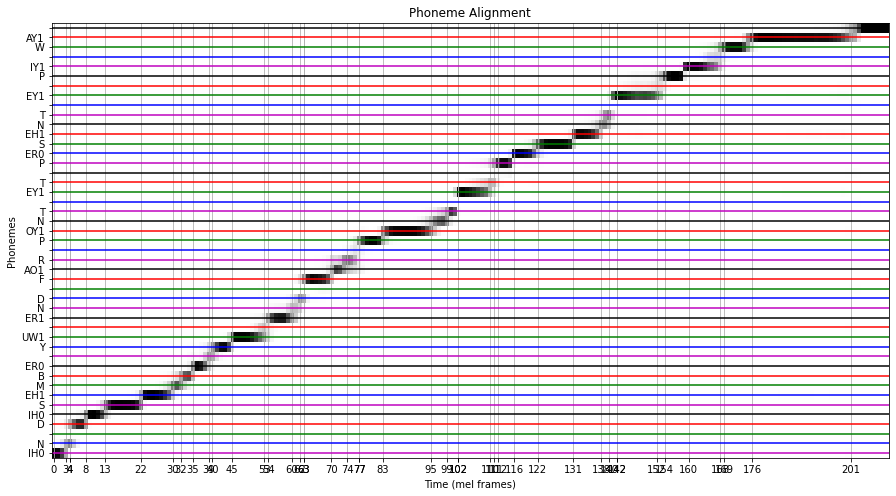

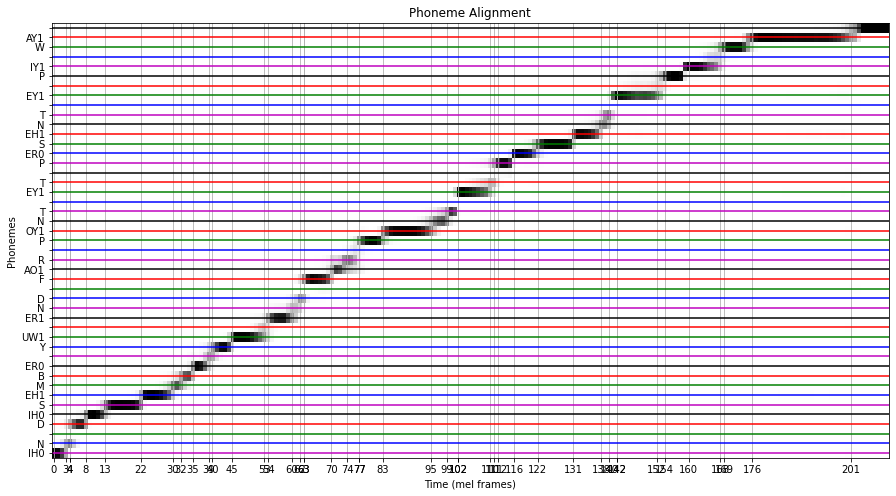

In [ ]:
%matplotlib inline

plot_attention_phonemes(sequence, attn[0].transpose(0, 1), NVIDIA_TACO2_SYMBOLS)

In [ ]:
torch.save(
    mel_out_postnet,
    "/Users/zwf/code/yotta-merge/mel_templates/best_month_apy_december.pt",
)

In [ ]:
_audio3 = torch.FloatTensor(audio) / 32768
stft = MelSTFT()
print(stft.mel_spectrogram(_audio3[None]).shape)
print(mel_out_postnet.shape)

In [ ]:
# original_sequence = torch.LongTensor(
#     text_to_sequence(
#         "This year you won 69 dollars.",
#         ["english_cleaners"],
#         p_arpabet=1,
#         symbol_set=NVIDIA_TACO2_SYMBOLS,
#     )
# )
# new_sequence = torch.LongTensor(
#     text_to_sequence(
#         "This year you won 4 dollars.",
#         ["english_cleaners"],
#         p_arpabet=1,
#         symbol_set=NVIDIA_TACO2_SYMBOLS,
#     )
# )
# embedded_inputs = model.embedding(original_sequence[None]).transpose(1, 2)
# embedded_text = model.encoder.inference(embedded_inputs)
# encoder_outputs1 = torch.cat((embedded_text,), dim=2)

# embedded_inputs = model.embedding(new_sequence[None]).transpose(1, 2)
# embedded_text = model.encoder.inference(embedded_inputs)
# encoder_outputs2 = torch.cat((embedded_text,), dim=2)
# print(encoder_outputs2.shape)
# encoder_outputs1[:, :14, :] - encoder_outputs2[:, :14, :]

In [ ]:
original_sequence = torch.LongTensor(
    text_to_sequence(
        "This year you won 69 dollars.",
        ["english_cleaners"],
        p_arpabet=1,
        symbol_set=NVIDIA_TACO2_SYMBOLS,
    )
)
new_sequence = torch.LongTensor(
    text_to_sequence(
        "You had 123 tickets.",
        ["english_cleaners"],
        p_arpabet=1,
        symbol_set=NVIDIA_TACO2_SYMBOLS,
    )
)
print(len(new_sequence))
print(sequence)
print(mel_out_postnet.transpose(1, 2).shape)
_mel_out, _mel_out_postnet, _gate_out, _attn = model.inference_partial_tf(
    (new_sequence[None],),
    mel_out_postnet,
    19,
    # encoder_until_idx=14, original_sequence=original_sequence[None],
)
audio = hg.infer(_mel_out_postnet)
display(Audio(audio, rate=22050))

37
tensor([145, 141,  11, 106,  70,  90,  11, 131, 109, 116, 131, 133, 112,   1,
        102, 133,  11, 116, 102,  11, 133, 109, 116,  73, 133, 131,  11,   7])
torch.Size([1, 161, 80])
torch.Size([1, 80, 183])
weight norm already removed


In [ ]:
shortened_attn = torch.empty(
    prev_attn.shape[1] // 2, prev_attn.shape[0], prev_attn.shape[2]
)
shortened_attn.shape
for idx in range(len(shortened_attn)):
    shortened_attn[idx, :, :] = (
        prev_attn[:, 2 * idx, :] + prev_attn[:, 2 * idx + 1, :]
    ) / 2

In [ ]:
plot_attention(shortened_attn.transpose(0, 1)[0])